# **Exploring NYC Rental Property Data**
---
*Data Science Project by Trenton vonHartitzsch (tcv2956) and Sean Lee (jsl775)*
---

# Introduction and Data Retrieval

Throughout NYC, a vast population of residents rely on rental properties for housing, which can vary greatly based on location, the number of bedrooms and bathrooms, as well as price. With this data science project, we aim to explore NYC rental property data to derive insights regarding apartment data, fostering data-driven decision making on where a user should best look for a rental property based on their specifications. With this project, we aim to:


● Analyze a key factor, like location

● Identify patterns and trends in NYC rental property data within isochronic
shapes surrounding specified locations

● Build multiple models to help gain insights on determining apartment recommendations (work, school, gym, etc.)




---


The notebook is organized in the following order:

1.   Introduction and Data Retrieval
2.   Setup and Installation
3.   Data Pre-Processing
4.   General Dataset Exploration and Analysis
5.   TravelTime API Function Implementation
6.   Isochrone and Intersection Mapping
7.   Isochrone Data Analysis
8.   Final Thoughts and Conclusion



To acquire this data on NYC rental properties, we used a data set found on APIFY, a cloud platform for web scraping. The data was collected using web scraping techniques within one of their APIs. This data was scraped on April 29, 2024 and was validated via URLs directly found within the scraped csv file.

# Setup and Installation

In [ ]:
# install external libraries necessary for our project:
# geopandas, pandas, matplotlib, requests, folium
!pip install geopandas pandas matplotlib requests folium

# to install traveltimepy, we are using version 3.9.6 because
# 3.9.7 is currently having stability issues that affect our code
!pip install traveltimepy==3.9.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 439.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.21.12 which is incompatible.


In [ ]:
# import packages from libraries for analysis, data pre-processing, and visualizations
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from traveltimepy import TravelTimeSdk
from IPython.display import display, HTML
import sklearn.preprocessing as skp
from sklearn.cluster import KMeans
import folium
from scipy import stats

In [ ]:
app_id = os.getenv('TRAVELTIME_APP_ID', '981c6f8d')
api_key = os.getenv('TRAVELTIME_API_KEY', 'c5fffce90d3ee3c78d1aa2f07ca93be3')

sdk = TravelTimeSdk(app_id=app_id, api_key=api_key)

# Data Pre-Processing

In [ ]:
# read csv file, store as 'df'
df = pd.read_csv("ZillowScrape.csv")

for column in df.columns:
  print(column) # print out columns to see all of them, pick out which ones are relevant

df.head(3) # to get a general idea of the dataset

address
addressCity
addressState
addressStreet
addressZipcode
area
availabilityCount
availabilityDate
badgeInfo/text
badgeInfo/type
baths
beds
brokerName
buildingName
canSaveBuilding
carouselPhotos/0/url
carouselPhotos/1/url
carouselPhotos/2/url
carouselPhotos/3/url
carouselPhotos/4/url
carouselPhotos/5/url
carouselPhotos/6/url
carouselPhotos/7/url
carouselPhotos/8/url
carouselPhotos/9/url
carouselPhotos/10/url
carouselPhotos/11/url
carouselPhotos/12/url
carouselPhotos/13/url
carouselPhotos/14/url
carouselPhotos/15/url
carouselPhotos/16/url
carouselPhotos/17/url
carouselPhotos/18/url
carouselPhotos/19/url
carouselPhotos/20/url
carouselPhotos/21/url
carouselPhotos/22/url
carouselPhotos/23/url
carouselPhotos/24/url
carouselPhotos/25/url
carouselPhotos/26/url
carouselPhotos/27/url
carouselPhotos/28/url
carouselPhotos/29/url
carouselPhotos/30/url
carouselPhotos/31/url
carouselPhotos/32/url
carouselPhotos/33/url
carouselPhotos/34/url
carouselPhotos/35/url
carouselPhotos/36/url
carouselPhoto

,address,addressCity,addressState,addressStreet,addressZipcode,area,availabilityCount,availabilityDate,badgeInfo/text,badgeInfo/type,...,variableData/data/isFresh,variableData/data/isRead,variableData/text,variableData/type,zestimate,zoomQuadrantSequence/0,zoomQuadrantSequence/1,zoomQuadrantSequence/2,zoomQuadrantSequence/3,zpid
0,"776 6th Ave, New York, NY",New York,NY,776 6th Ave # 27M,10001,NaN,23.0,NaN,NaN,NaN,...,NaN,NaN,3D Tour,3D_HOME,NaN,NaN,NaN,NaN,NaN,40.744976--73.99104
1,"11 E 1st St, New York, NY",New York,NY,11 E 1st St # 5a738dede,10003,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,TIME_ON_INFO,NaN,NaN,NaN,NaN,NaN,40.724564--73.991486
2,"160 W 24th St, New York, NY",New York,NY,160 W 24th St # 1-14F,10011,NaN,13.0,NaN,NaN,NaN,...,NaN,NaN,3D Tour,3D_HOME,NaN,NaN,NaN,NaN,NaN,40.744576--73.99493


Looking through the columns, we first looked at the columns: `address`, `area`, `units/{i}/beds`, `baths`, `units/{i}/price`, `latLong/latitude`, and `latLong/longitude`. For clarification, if a listing has "0" beds, it simply means the apartment is a studio and has no separate rooms for the bed.

 We first decided to check for the NA count for columns, to see whether or not they would be viable to use in our analysis later on. We we will not be looking at `units/{i}/beds` or `units/{i}/price` as apartments will vary in the number of bedrooms.



In [ ]:
# create a list of tentative columns that we plan on using for our project
tentative_columns = ['address', 'area', 'baths', 'latLong/latitude', 'latLong/longitude']

# for loop that prints the number of na values in each of these columns
print("# of NA values by column")
for column in tentative_columns:
  print(column, ':', np.sum(df[column].isna()))

print()
print(f'The dataframe has {df.shape[0]} rows') # print number of rows to get a grasp of how impactful the NaN values are

# of NA values by column
address : 0
area : 2836
baths : 982
latLong/latitude : 0
latLong/longitude : 0

The dataframe has 3486 rows


Based on our tentative columns for our final dataframe, we see that out of 3486 rows, 2836 do not have data for `area`. Thus, we will not use it. Now that we know the relevant columns, we can move onto further pre-processing. As for missing values in `baths`, we know that apartments MUST have a bathroom in the vicinity, and thus will default the value as 1.

In [ ]:
# helper function clean_price, removes unnecessary characters from 'price' column
# to only get price in float form. If no price, returns NaN
def clean_price(price):
    if pd.notna(price):
        return float(price.replace('$', '').replace(',', '').replace('+', '').replace('/mo', ''))
    return np.nan

expanded_rows = []

# for loop that iterates over each row in the original df
for _, row in df.iterrows():
    row_added = False  # flag to check if any row was added for this entry

    # for loop that checks each unit column from 0 to 5 (assuming a maximum of 6 units as an example cause i saw nothing above 6)
    for i in range(6):
        unit_beds = row.get(f'units/{i}/beds')
        unit_price = row.get(f'units/{i}/price')
        unit_baths = row.get(f'baths')

        # if statement that checks if unit beds is a valid value to insert
        if pd.notna(unit_beds):
            beds = int(unit_beds) # cast as int

            # normalize NaN 'bath' values for studios and 1 bedroom units, if applicable
            if pd.isna(unit_baths) and beds == 1:
                unit_baths = 1.0

            # skip rows where beds are zero (no apartments available)
            if beds > 0:
                # create a new row for each bed unit based on the number of beds
                for _ in range(beds):
                    new_row = {
                        'address': (row['address']),
                        'beds': beds,
                        'baths': unit_baths if pd.notna(unit_baths) else np.nan,
                        'price': clean_price(unit_price),
                        'latitude': row.get('latLong/latitude', None),
                        'longitude': row.get('latLong/longitude', None),
                    }
                    expanded_rows.append(new_row)
                    row_added = True

    # if statement for case when no rows have been added from any unit, consider adding the original row if necessary
    if not row_added:
        new_row = {
            'address': row['address'],
            'beds': row.get('beds'),
            'baths': row.get('baths') if pd.notna(row['baths']) else np.nan,
            'price': clean_price(row.get('price')),
            'latitude': row.get('latLong/latitude', None),
            'longitude': row.get('latLong/longitude', None),
        }
        expanded_rows.append(new_row)

# create a new df 'expanded_df' from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# some price values within the DataFrame had irregular values for those columns. The prices are adjusted here
indices_to_update = [154, 155, 156, 157]
expanded_df.loc[indices_to_update, 'price'] = 7250

expanded_df.head(3) # print to check if code works properly
expanded_df.shape

(5556, 6)

Now that we have reformatted the data so that each variable is now separate and organized in its proper column, we did further pre-processing by removing NaN values, as well as implementing feature engineering by adding columns `neighborhood` (derived from latitude and longitude) and `total rooms` (derived from adding the number of bedrooms and bathrooms with a "base room" like a living room).

In [ ]:
# remove rows with NaN values in 'beds', 'baths', and 'price'
# declare how as 'all' so that ONLY columns where ALL 3 columns are NaN are dropped
temp_df = expanded_df.dropna(subset=['beds', 'baths', 'price'], how='all')
temp_df.shape

(5507, 6)

In [ ]:
### Now we need to replace NaN 'baths' values with its average based on the number of beds in the apartment ###

# create a function that determines average number of bathrooms in apartments that have NaN as bathroom, round to nearest whole number
bath_means = temp_df.groupby('beds')['baths'].mean().round(0)

# function fill_bathrooms, takes a row in dataframe as input. if the row has an
# NaN value for 'baths', replace with the calculated average
def fill_bathrooms(row):
    if pd.isna(row['baths']):
        return bath_means.get(row['beds'], np.nan)  # default to NaN if no mean available for that bed count
    return row['baths']

cleaned_df = temp_df.copy() # create a copy of the temporary dataframe to store as cleaned_df
cleaned_df['baths'] = cleaned_df.apply(fill_bathrooms, axis=1) # apply function 'fill_bathrooms' to 'baths' column

In [ ]:
# Feature engineering, adding 'neighborhood' column
# To implement the column 'neighborhood', we created a mapping dictionary based on
# neighborhood name, latitude, and longitude.

neighborhood_data = { # Hand collected via Google Maps
    "name": ["Alphabet City", "Battery Park City", "Carnegie Hill", "Chelsea", "Chinatown",
             "Clinton", "East Harlem", "East Village", "Financial District", "Flatiron District",
             "Gramercy Park", "Greenwich Village", "Harlem", "Hells Kitchen", "Inwood",
             "Kips Bay", "Lincoln Square", "Little Italy", "Lower East Side", "Manhattan Valley",
             "Midtown East", "Morningside Heights", "Murray Hill", "Roosevelt Island", "SoHo",
             "Tribeca", "Upper East Side", "Upper West Side", "Washington Heights", "West Village"],
    "latitude": [40.726000, 40.713000, 40.784726, 40.746000, 40.715000,
                 40.764000, 40.795000, 40.728000, 40.708000, 40.740800,
                 40.737800, 40.734000, 40.815130, 40.764000, 40.867000,
                 40.741000, 40.773828, 40.719000, 40.715000, 40.799353,
                 40.747000, 40.809722, 40.748000, 40.761389, 40.723000,
                 40.718000, 40.769000, 40.787000, 40.840000, 40.736000],
    "longitude": [-73.979000, -74.016000, -73.956070, -74.001000, -73.997000,
                  -73.992000, -73.939000, -73.986000, -74.011000, -73.989600,
                  -73.986100, -74.002000, -73.947515, -73.992000, -73.922000,
                  -73.978000, -73.984472, -73.997000, -73.985000, -73.962919,
                  -73.986000, -73.960278, -73.978000, -73.950833, -74.000000,
                  -74.008000, -73.966000, -73.975000, -73.940000, -74.004000]
}

neighborhoods = pd.DataFrame(neighborhood_data) # store as a dataframe

# Implementation of haversine function to find the distance between two coordinates (latitude and longitude)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c  # Distance in kilometers
    return distance

# function find_neighborhood, takes latitude and longitude values of apartment in dataframe
# and calculates the distances for each neighborhood, returning the name of the neighborhood
# that the apartment has the minimum distance to
def find_neighborhood(lat, lon):
    distances = neighborhoods.apply(lambda row: haversine(lat, lon, row['latitude'], row['longitude']), axis=1)
    return neighborhoods.loc[distances.idxmin(), 'name']

# apply function to dataframe to get neighborhood values, store in new column 'neighborhood'
cleaned_df['neighborhood'] = cleaned_df.apply(lambda row: find_neighborhood(row['latitude'], row['longitude']), axis=1)

# Add another instance of feature engineering: 'total rooms'.
# Default is 1, which is aggregated with the number of bedrooms and bathrooms
cleaned_df['total rooms'] = (1 + cleaned_df['beds'] + cleaned_df['baths'])

# Add one last feature engineering: 'grade'
# This is a rough overall 'grade' of the apartments avaliable. This is determined by the ratio of 'total rooms' vs 'price'
# The scale is 1-10 and normalized. This is to help detemine the best price for your space
cleaned_df['room price ratio'] = cleaned_df['total rooms'] / cleaned_df['price']
# Usage of the MinMax scaler because of the desire to make the values on a 1-10 scale
scaler = skp.MinMaxScaler(feature_range=(1, 10))
cleaned_df['grade'] = scaler.fit_transform(cleaned_df[['room price ratio']])
cleaned_df.drop('room price ratio', axis=1, inplace=True)

# now that we have implemented feature engineering, we can remove rows that have outliers in columns 'price'
processed_df = cleaned_df[cleaned_df['price'].apply(lambda x: np.abs(x - (cleaned_df['price']).mean()) / cleaned_df['price'].std() < 3)]


In [ ]:
print("Shape: ", processed_df.shape) # print shape to better understand how many rows

processed_df.head(5)

Shape:  (5398, 9)


,address,beds,baths,price,latitude,longitude,neighborhood,total rooms,grade
0,"776 6th Ave, New York, NY",1.0,1.0,5063.0,40.744976,-73.991040,Flatiron District,3.0,3.035368
1,"776 6th Ave, New York, NY",2.0,1.0,8978.0,40.744976,-73.991040,Flatiron District,4.0,2.483882
2,"776 6th Ave, New York, NY",2.0,1.0,8978.0,40.744976,-73.991040,Flatiron District,4.0,2.483882
3,"11 E 1st St, New York, NY",1.0,1.0,6498.0,40.724564,-73.991486,East Village,3.0,2.544459
4,"11 E 1st St, New York, NY",2.0,1.0,5620.0,40.724564,-73.991486,East Village,4.0,3.482595


After pre-processing, we have come up with the dataframe we plan to use in our analysis and model building. The DataFrame has 5398 rows and 9 columns. As a side note, we are omitting from normalizing the columns just yet, as interpreting our analysis will be more tangible with the actual prices. We will normalize the data for regression and clustering later when we analyze isochrone intersection apartment data.

# General Dataset Exploration and Analysis

Before going into the exploring and analyzing of apartments within isochrone intersections, we plan on comprehensively exploring the whole dataset. For each of the numerical categories, we provided descriptive statistics and plotted a histogram depicting the distribution of values in each column.

Beds Descriptive Statistics
   Mean:   2.04
   Median: 2.0
   Mode:   2.0
   St Dev: 1.15



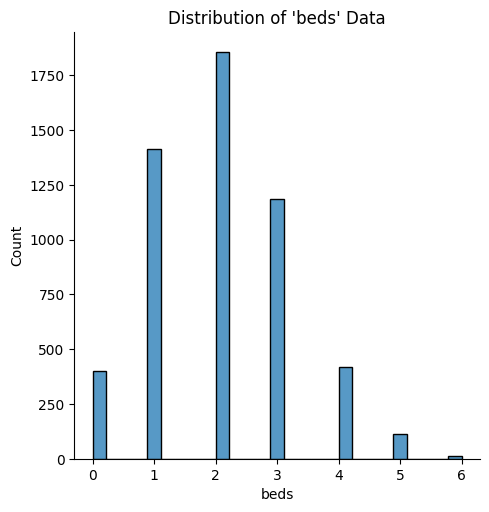

In [ ]:
import seaborn as sns

# for column 'beds' plot a histogram using seaborn
beds_distribution = sns.displot(data = processed_df, x = 'beds').set(title = "Distribution of 'beds' Data")
# print out descriptive statistics
print("Beds Descriptive Statistics")
print(f"   Mean:   {round(processed_df['beds'].mean(), 2)}")
print(f"   Median: {round(processed_df['beds'].median(), 2)}")
print(f"   Mode:   {round(processed_df['beds'].mode()[0], 0)}")
print(f"   St Dev: {round(processed_df['beds'].std(), 2)}")
print()


In [ ]:
# to further confirm the distribution of beds, we are using stats.describe to get variance, skewness, and kurtosis
stats.describe(processed_df.beds)

DescribeResult(nobs=5398, minmax=(0.0, 6.0), mean=2.037791774731382, variance=1.3130054619149154, skewness=0.3687933300586163, kurtosis=-0.0390447557102247)

Based on the descriptive statistics and histogram visualizing the distribution of 'beds', the data appears to be normal at an average of 2.04 beds for an apartment. While the data is relatively normal, there is a slight skew to the right as the number of bedrooms in an apartment increases, with the mean being greater than the median. To check again, we can use stats.describe to better understand the distribution of data.

Using stats.describe, we get low skewness values, suggesting that the column `beds` has a useable normal distribution.

*For clarification, we should also interpret '0 beds' to mean 'studio'.*

Baths Descriptive Statistics
   Mean:   1.46
   Median: 1.0
   Mode:   1.0
   St Dev: 0.74



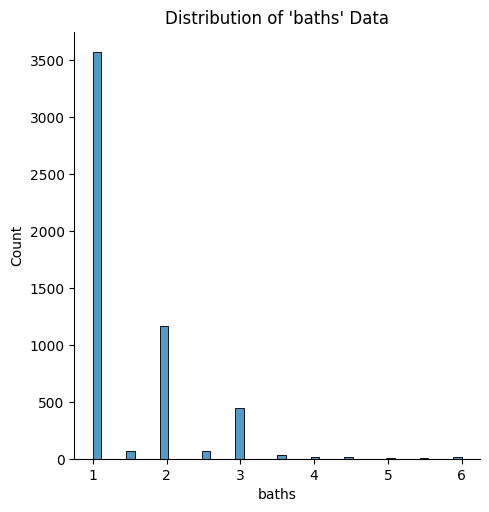

In [ ]:
# for column 'baths'
baths_distribution = sns.displot(data = processed_df, x = 'baths').set(title = "Distribution of 'baths' Data")
print("Baths Descriptive Statistics")
print(f"   Mean:   {round(processed_df['baths'].mean(), 2)}")
print(f"   Median: {round(processed_df['baths'].median(), 2)}")
print(f"   Mode:   {round(processed_df['baths'].mode()[0], 1)}")
print(f"   St Dev: {round(processed_df['baths'].std(), 2)}")
print()

Upon looking at the descriptive statistics and histogram depicting distribution of 'baths' data, we can see that the data is heavily skewed to the right. Not only is the mean greater than the median (1.46 > 1), but as the number of bathrooms increase, the count drastically drops. This suggests that the majority of apartments only have one bathroom, less have two, even less have three, and so on. The histogram also highlights the presence of "half bathrooms", bathrooms that do not house full amenities like a shower.

Price Descriptive Statistics
   Mean:   $6752.83
   Median: $5000.0
   Mode:   $4500.0
   St Dev: $4952.38



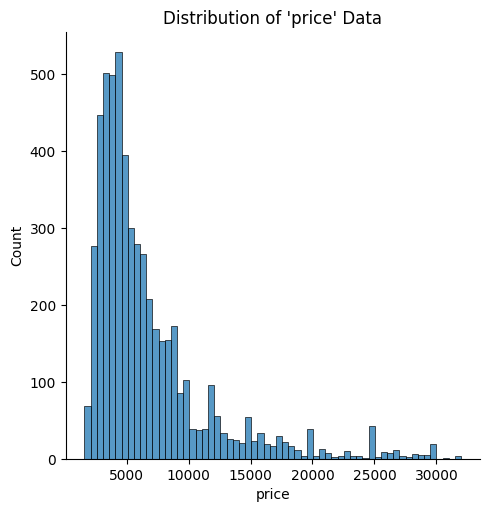

In [ ]:
# for column 'price', print a histogram to visualize the distribution of data
price_distribution = sns.displot(data = processed_df, x = 'price').set(title = "Distribution of 'price' Data")
# print descriptive statistics
print("Price Descriptive Statistics")
print(f"   Mean:   ${round(processed_df['price'].mean(), 2)}")
print(f"   Median: ${round(processed_df['price'].median(), 2)}")
print(f"   Mode:   ${round(processed_df['price'].mode()[0], 1)}")
print(f"   St Dev: ${round(processed_df['price'].std(), 2)}")
print()

In [ ]:
# to further confirm the distribution of price, we are using stats.describe to get variance, skewness, and kurtosis
stats.describe(processed_df.price)

DescribeResult(nobs=5398, minmax=(1600.0, 32000.0), mean=6752.831789551686, variance=24526043.251670357, skewness=2.240537968962258, kurtosis=5.692106147734787)

Like the `baths` column, `price` is also heavily skewed to the right. The mean is greater than the median price, and the histogram's shape suggests the same distribution. We find an existing pattern that as the price goes up, the number of existing apartments decreases.

Running stats.describe on the `price` column, we also find that there is very high variance, a high positive skewness, and high kurtosis values, confirming that the distribution is heavily right-tailed and not normal.

We can interpret this distribution to mean that most apartments hover around a median of $5000, with the count of apartments decreasing as they increase in price.

We also looked at `neighborhood` data, grouping by the column. We aggregated counts and observed boxplots of price for each of these neighborhoods to better understand the data.

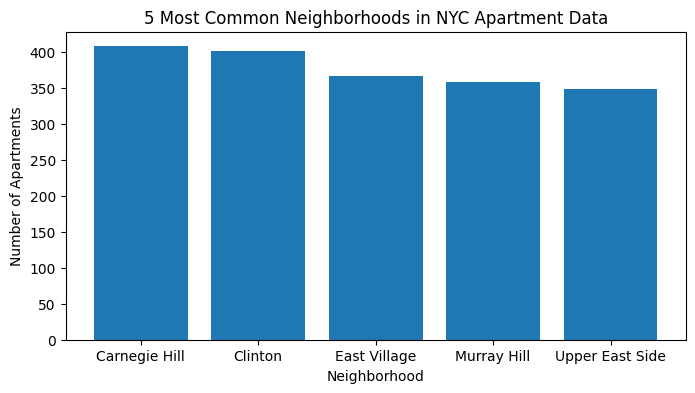

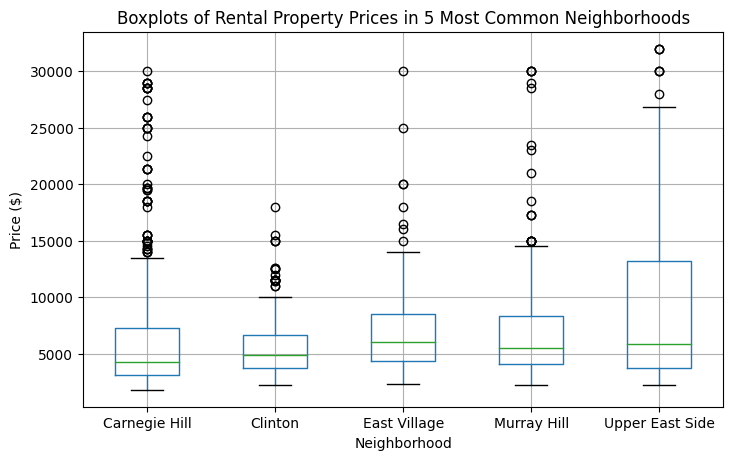

In [ ]:
# use value_counts to aggregate the number of apartments for each neighborhood
top_neighborhoods = processed_df['neighborhood'].value_counts()

# index to get top 5 neighborhoods, split into index and values
top5_neighborhoods = top_neighborhoods[0:5]

top5_neighborhood = top5_neighborhoods.index
top5_count = top5_neighborhoods.values

# plot findings of top 5 neighborhoods by count
plt.figure(figsize=(8,4))
plt.bar(top5_neighborhood, top5_count)
plt.title('5 Most Common Neighborhoods in NYC Apartment Data')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Apartments')
plt.show()

print("")
temp_df = processed_df[processed_df['neighborhood'].apply(lambda x: x in top5_neighborhood)]

# plot boxplot to visualize distribution of price between each neighborhood
top5_boxplots = temp_df.loc[:,['neighborhood','price']].boxplot(by='neighborhood', column='price', figsize = (8,5))
top5_boxplots.plot()
plt.title("Boxplots of Rental Property Prices in 5 Most Common Neighborhoods")
plt.xlabel("Neighborhood")
plt.ylabel("Price ($)")
plt.suptitle("")
plt.show()

Based on the bar chart, the top 5 most common neighborhoods in the NYC Rental Property dataset are: Carnegie Hall, Clinton, East Village, Murray Hill, and Upper East Side.


Observing the boxplots that visualize the distribution and summary statistics of each of these neighborhoods, we can also make several inferences. For one, Carnegie Hall has a wide range of prices for its apartments, with a large amount of outliers at the top, indicating luxury housing. This wide range can indicate that there is wide variability in terms of housing, potentially based on if it is standard or luxury housing. In another instance, we see that Clinton has a very uniform interquartile range, suggesting that the rent is fairly uniform across most apartments, in spite of some outliers. In a neighborhood like the Upper East side, the narrow bottom 50% of data, contrasted with the wide variability and outliers in the top 50% of data, suggests that standard, lower-priced apartments are fairly narrowly distributed in price, while higher-priced luxury apartments can vary signficiantly more.

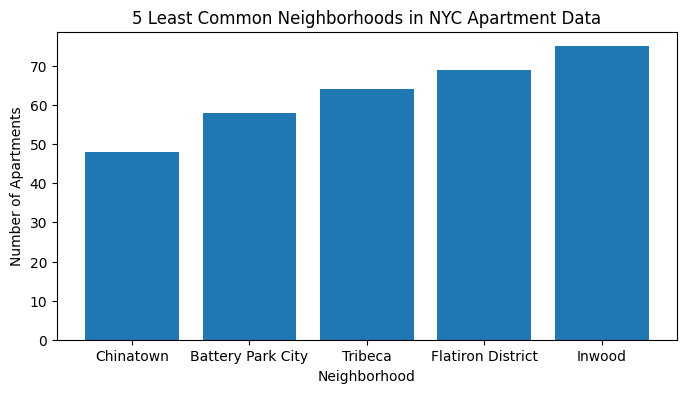

In [ ]:
# we can also take a look at the five neighborhoods with the least amount of listed apartments
# start at '-5' to get 5 least occurring neighborhoods, sort_values to reverse list
bottom5_neighborhoods = top_neighborhoods[-5::].sort_values()
bottom5_neighborhoods

bottom5_neighborhood = bottom5_neighborhoods.index
bottom5_count = bottom5_neighborhoods.values

# plot figure
plt.figure(figsize=(8,4))
plt.bar(bottom5_neighborhood, bottom5_count)
plt.title('5 Least Common Neighborhoods in NYC Apartment Data')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Apartments')
plt.show()

In [ ]:
print("Corr between # of beds and price: ", stats.pearsonr(processed_df['total rooms'], processed_df['latitude']))
print("Corr between # of baths and price: ", stats.pearsonr(processed_df['baths'], processed_df['price']))
print("Corr between # of total rooms and price: ", stats.pearsonr(processed_df['total rooms'], processed_df['price']))

Corr between # of beds and price:  PearsonRResult(statistic=-0.02350657776258393, pvalue=0.08418699985720508)
Corr between # of baths and price:  PearsonRResult(statistic=0.5905038428225114, pvalue=0.0)
Corr between # of total rooms and price:  PearsonRResult(statistic=0.5877040482350793, pvalue=0.0)


Based on the correlation ran between the three numerical variables `beds`, `baths`, `total rooms`, and `price`, we notice that all three instances of Pearson correlations produce a statistic value of 0.53, 0.59, and 0.59. These values indicate a moderately strong positive direct relationship for all three pairs of variables. The p-value being listed as 0.0 for each of these correlations corroborates this relationship, as the value being less than 0.05 means we can reject the null hypothesis that the correlation coefficient between these variables is 0. We expected these values, as it makes sense for the price of an apartment to go up with the increase of area and utility in the form of bedrooms and bathrooms.

We can run significance tests to explore further questions related to our dataset. For instance, we would first like to run a 2-sample t-test to identify if there is a statistically significant difference between two distributions of bed counts between the neighborhoods 'East Village' and 'Murray Hill'.

In [ ]:
sample_one = processed_df[processed_df['neighborhood']=="East Village"]
sample_two = processed_df[processed_df['neighborhood']=="Murray Hill"]

stats.ttest_ind(sample_one['beds'], sample_two['beds'])

TtestResult(statistic=5.589021145989148, pvalue=3.236793151667449e-08, df=723.0)

We can interpret the results of this two-sample t-test by looking at the p-value. Since the p-value is 3.24*10^-8, which is less than an alpha value of 0.05, we reject the null hypothesis that there is no statistically significant difference in means between the two neighborhoods East Village and Murray Hill.

On a side note, while we did want to conduct an ANOVA to compare prices between certain neighborhoods, since price is not normally distributed, we were not able to use the test. That said, non-parametric tests were not in the course notes, so we thus operated under the assumption that non-parametric tests like Kruskal-Wallis, Mann-Whitney U were not allowed.

# TravelTime API Function Implementation

In [ ]:
# import necessary libraries for function implementation, and later isochrone/intersection visualization
import asyncio
from datetime import datetime
from traveltimepy import Driving, PublicTransport, Walking, Cycling, Coordinates, TravelTimeSdk
import geopandas as gpd
from shapely.geometry import Polygon, shape
import matplotlib.pyplot as plt

In [ ]:
# these functions were sourced from the official TravelTime API, comments included to help explain the purpose of each

# function geocode_address: takes an address as an input, returns latitude and longitude values based on given query
async def geocode_address(address):
    results = await sdk.geocoding_async(query=address, limit=1, format_name=True)
    if results.features:
        point = shape(results.features[0].geometry)
        longitude = point.x
        latitude = point.y
        return Coordinates(lat=latitude, lng=longitude)
    else:
        print("No valid coordinates found.")
        return None

# function fetch_isochrones: takes coordinates, user inputted arrival time, travel time, and transportation
# returns isochrone
async def fetch_isochrones(coordinates, arrival_time, travel_time, transportation):
    results = await sdk.time_map_async(
        coordinates=coordinates,
        arrival_time=arrival_time,
        travel_time=travel_time,
        transportation=transportation
    )
    return results

# function find_intersection_or_union: takes coordinates and mode (intersection or union) as an input
# for the purpose of our project, we will only be using intersection
# returns intersection of isochrones
async def find_intersection_or_union(coordinates, mode):
    arrival_time = datetime.now()
    if mode == "intersection":
        return await sdk.intersection_async(
            coordinates=coordinates,
            arrival_time=arrival_time,
            transportation=Driving()
        )
    elif mode == "union":
        return await sdk.union_async(
            coordinates=coordinates,
            arrival_time=arrival_time,
            transportation=Driving()
        )

# function fetch_distance_map: takes coordinates, arrival time, travel distance, and transportation information into account
async def fetch_distance_map(coordinates, arrival_time, travel_distance, transportation):
    results = await sdk.distance_map_async(
        coordinates=coordinates,
        arrival_time=arrival_time,
        travel_distance=travel_distance,
        transportation=transportation
    )
    return results

# Isochrone and Intersection Mapping

Using the added TravelTime API functions, we can create an ischrone map, a map that portrays the area accessible to a certain location within a certain timeframe, for a number of listed locations. In this section, we will demo a user input in which:
*   The user would like to access their locations within 30 minutes by public_transport.
*   Their listed locations are:
  *   Morgan Stanley NY Office (1585 Broadway, New York, NY 10036)
  *   Washington Square Park
  *   Columbus Circle

*As a side note, the parentheticals for locations refer to how the user inputs the information. Inputting the full address or a common name can better help identify addresses.*

The result will display geographic visualizations of the isochrones for each location. Using these isochrones, we can later look at their intersections, and the apartment data within this intersection.

In [ ]:
async def main():

    # declare variables and data fields
    sdk = TravelTimeSdk("981c6f8d", "c5fffce90d3ee3c78d1aa2f07ca93be3")
    global origin_coordinates
    global transportation
    global travel_time_seconds

    # initialize array containing origin coordinates
    origin_coordinates = []

    # dictionary containing different modes of transportation
    transportation_options = {
    'walking': Walking,
    'cycling': Cycling,
    'driving': Driving,
    'public_transport': PublicTransport
    }

    # declare nyc_map, a folium Map of NYC
    nyc_map = folium.Map(location=[40.7415696, -74.0022074], zoom_start=13, tiles='CartoDB dark_matter', control_scale=True)

    # user input for total preferred travel time. in our instance, we inputted 30
    travel_time_minutes = input("Enter the total travel time you woud like in minutes: ")
    try:
        travel_time_seconds = int(travel_time_minutes) * 60 # convert to seconds for use in TravelTime functions
    except ValueError: # catch potential error, print error, set travel time to 1200 (20 min)
        print("Invalid input for travel time. Using a default of 20 minutes.")
        travel_time_seconds = 1200

    # next ask user input for mode of transportation
    print("Choose a method of transportation: walking, cycling, driving, public_transport")
    transport_method = input("Enter your choice: ").lower()
    # if statement to check for valid transportation method. if invalid, set to public_transport
    if transport_method in transportation_options:
        transportation = transportation_options[transport_method]()
    else:
        print("Invalid transportation method selected. Defaulting to public transport.")
        transportation = PublicTransport()

    # for loop that iterates through a maximum of 5 possible addresses
    for i in range(5):
        global user_address
        user_address = input(f"Please enter address #{i+1} (up to 5): ")
        user_coordinates = await geocode_address(user_address) # use geocode_address to get user_coordinates
        # if statement to check that coordinates are valid, in which case add to nyc_map
        if user_coordinates:
            origin_coordinates.append(Coordinates(lat=user_coordinates.lat, lng=user_coordinates.lng))
            nyc_map.location = [user_coordinates.lat, user_coordinates.lng]
            popup_content = f'<div style="width:200px;">{user_address}</div>'
            folium.Marker(
                [user_coordinates.lat, user_coordinates.lng],
                popup=folium.Popup(popup_content, max_width=265),
                icon=folium.Icon(color='blue')
            ).add_to(nyc_map)
        # if statement that iterates to ask if user would like to continue inputting more addresses, break loop if 'no'
        if i < 4:
            add_more = input("Would you like to input another address? (yes/no): ")
            if add_more.lower() != 'yes':
                break

    # fetch the isochrones for the center coordinates
    results = await sdk.time_map_geojson_async(
        coordinates=origin_coordinates,
        arrival_time=datetime.now(),
        travel_time= travel_time_seconds,
        transportation=transportation
    )

    # create list of colors that isochrone will use in visualization
    colors = ['red', 'blue', 'green', 'yellow', 'purple']

    # for loop that plots each isochrone on the map
    for i, feature in enumerate(results.features):
        folium.GeoJson(feature, style_function=lambda x, color=colors[i]: {'color': color}).add_to(nyc_map)

    # display folium map
    display(nyc_map)

# try&except block, this is a precaution as the TravelTime API has a max call amount per minute with the free plan we are using
try:
    await main()
except RuntimeError:
    asyncio.run(main())

Now that we have three locations plotted to an individual color, we can now plot the intersection between these isochrones.

In [ ]:
import asyncio
from datetime import datetime
import folium
from traveltimepy import TravelTimeSdk, Coordinates, PublicTransport
from shapely.geometry import shape
from shapely.ops import unary_union

# function fetch_isochrones: takes coordinates, user inputted arrival time, travel time, and transportation
# returns isochrone
# this function provides the intersected area of all isochrones developed in the above graph
async def fetch_isochrones(origin_coordinates):
    sdk = TravelTimeSdk("981c6f8d", "c5fffce90d3ee3c78d1aa2f07ca93be3")

    # fetch the isochrones for the center coordinates
    features = await sdk.time_map_geojson_async(
        coordinates=origin_coordinates,
        arrival_time=datetime.now(),
        travel_time=travel_time_seconds,
        transportation=transportation
    )

    geoms = [shape(feature.geometry) for feature in features.features]

    # compute the intersection of all geometries
    intersection = unary_union(geoms)
    for geom in geoms:
        intersection = intersection.intersection(geom)

    # create a map using folium of New York
    m = folium.Map(location=[40.7415696, -74.0022074], zoom_start=13, tiles='CartoDB dark_matter')

    # plot the intersection if it's not empty
    if not intersection.is_empty:
        folium.GeoJson(intersection, style_function=lambda x: {'color': 'orange', 'weight': 5}).add_to(m)

    return m

# execute the async function and display the map in a cell
map_obj = await fetch_isochrones(origin_coordinates)
map_obj

From here, we can now plot apartments from our dataframe into the isochrone intersection, as well as produce a dataframe of said apartments for later analysis.

In [ ]:
import asyncio
from datetime import datetime
import folium
from folium.plugins import MarkerCluster
from traveltimepy import TravelTimeSdk, Coordinates, PublicTransport
from shapely.geometry import shape, Point
from shapely.ops import unary_union
import geopandas as gpd

# function fetch_isochrones: takes the intersected isochrone and the housing dataFrame
# returns a map of plotted apartments within the intersected isochrone
# this function is different from that above as it provides the housing data overtop the area
async def fetch_isochrones():
    global intersection
    sdk = TravelTimeSdk("981c6f8d", "c5fffce90d3ee3c78d1aa2f07ca93be3")

    # Fetch the isochrones
    features = await sdk.time_map_geojson_async(
        coordinates=origin_coordinates,
        arrival_time=datetime.now(),
        travel_time=travel_time_seconds,
        transportation=transportation
    )

    geoms = [shape(feature.geometry) for feature in features.features]

    # calculate the intersection of all geometries
    # if statement for geoms
    if geoms:
        intersection = geoms[0]  # Start with the first geometry
        for geom in geoms[1:]:
            intersection = intersection.intersection(geom)  # Intersect with each subsequent geometry

    m = folium.Map(location=[40.7415696, -74.0022074], zoom_start=13, tiles='CartoDB dark_matter')
    if intersection and not intersection.is_empty:
        folium.GeoJson(intersection, style_function=lambda x: {'color': 'orange', 'weight': 5}).add_to(m)
    return m

async def main():
    map_obj = await fetch_isochrones()

    marker_cluster = MarkerCluster().add_to(map_obj)

    # create a temporary geodataframe gdf that contains the geometry information
    gdf = gpd.GeoDataFrame(processed_df, geometry=gpd.points_from_xy(processed_df['longitude'], processed_df['latitude']), crs='EPSG:4326')
    # create column 'geometry' that stores the points derived from longitude and latitude
    gdf['geometry'] = gdf.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # filter gdf so that it only includes data within intersection
    gdf_within_intersection = gdf[gdf.geometry.within(intersection)]
    global intersected_df

    # create a dataframe intersected_df, dropping the 'geometry' column and resetting index
    intersected_df = pd.DataFrame(gdf_within_intersection.drop(columns='geometry')).reset_index(drop=True)

    # create a marker based on lat and long values for folium map, include pop-up which includes address information
    for idx, row in gdf_within_intersection.iterrows():
        folium.Marker([row['latitude'], row['longitude']], popup=row['address']).add_to(map_obj)
    # return map
    return map_obj

# run the script and display the map
map_obj = await main()
map_obj

# Isochrone Data Analysis

We can run some analysis on the dataset of apartments within this intersection of isochrones, as well as produce visualizations.

In [ ]:
print(intersected_df.shape)
# print shape of intersected_df, as well as price descriptive statistics
print("Price Descriptive Statistics")
print(f"   Mean:   ${round(intersected_df['price'].mean(), 2)}")
print(f"   Median: ${round(intersected_df['price'].median(), 2)}")
print(f"   Mode:   ${round(intersected_df['price'].mode()[0], 2)}")
print(f"   St Dev: ${round(intersected_df['price'].std(), 2)}")
print()

# rescale the grade column to be proportional to the applicable area
intersected_df['room price ratio'] = intersected_df['total rooms'] / intersected_df['price']
scaler = skp.MinMaxScaler(feature_range=(1, 10))
intersected_df['grade'] = scaler.fit_transform(intersected_df[['room price ratio']])
intersected_df.drop('room price ratio', axis=1, inplace=True)

# count top 5 neighborhoods in intersected_df
top_neighborhoods_intersection = intersected_df['neighborhood'].value_counts()
top5_neighborhood_intersection = top_neighborhoods_intersection[0:5]

top5_neighborhood = top5_neighborhood_intersection.index
top5_count = top5_neighborhood_intersection.values

# plot findings in barchart
plt.figure(figsize=(8,4))
plt.bar(top5_neighborhood, top5_count)
plt.title('Top 5 Most Common Neighborhoods Within Isochrone')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Apartments')
plt.show()

print(f'\nOut of the {intersected_df.shape[0]} apartments in the isochrone, here are the top 5 most commonly appearing neighborhoods.\n')

# create a temporary dataframe that only takes rows from top5 neighborhoods in intersected_df
temp_df = intersected_df[intersected_df['neighborhood'].apply(lambda x: x in top5_neighborhood)]

# plot boxplots that depict distribution of price between each neighborhood
top5_boxplots = temp_df.loc[:,['neighborhood','price']].boxplot(by='neighborhood', column='price', figsize = (8,5))
top5_boxplots.plot()
plt.title("Boxplots of Rental Property Prices in 5 Most Common Neighborhoods of Isochrone")
plt.xlabel("Neighborhood")
plt.ylabel("Price ($)")
plt.suptitle("")
plt.show()
print("")
# plot boxplots for grade
grade_df = temp_df[['neighborhood', 'beds', 'grade']]
grade_df['beds'] = grade_df['beds'].astype(str) + ' bed'
plt.figure(figsize=(12, 6))  # Set the figure size or adjust based on your dataset
sns.boxplot(data=grade_df, x='neighborhood', y='grade', hue='beds')  # 'hue' differentiates the bedroom counts
plt.title("Boxplots of Rental Property Grades by Neighborhood and Number of Bedrooms")
plt.xlabel("Neighborhood")
plt.ylabel("Grade")
plt.legend(title='Bedrooms', loc='upper right')
plt.xticks(rotation=45)
plt.show()

In [ ]:
top5_neighborhood_intersection

Looking at the boxplots of price distributions by neighborhood, we can first identify that Clinton has a fairly narrow range of prices compared to the other four neighborhoods. East Village and Murray Hill share similarities both in boxplot shape, suggesting similar distribution, and the presence of outliers. And like our observation in exploring the general dataframe, we also find that the Upper East side has a very narrow section for its bottom half of data, with a very high range from the maximum (excluding outlier) to the median, suggesting a wide range of luxury housing in the area.

The boxplot of rental property grades within the 5 most common neighborhoods provides good insight into the quality of the applicable apartments. Clinton, being the most common neighborhood, has the highest grade of apartments. Although Clinton has the highest grades, it is noted that the average grade is found just below that of East Village. Despite the top 5 neighborhoods all having relatively similar median apartment grades, it would be recommended that the buyer looks for apartments in the neighborhoods of Clinton, East Village, and Murry Hill as those neighborhoods have the highest average grade as well as the absolute highest grades.

In [ ]:
from scipy import stats
from sklearn.model_selection import train_test_split

# create columns that normalize the numeric data in our intersected_df
intersected_df['price_norm']=skp.MinMaxScaler().fit_transform(intersected_df['price'].values.reshape(-1,1))
intersected_df['beds_norm']=skp.MinMaxScaler().fit_transform(intersected_df['beds'].values.reshape(-1,1))
intersected_df['baths_norm']=skp.MinMaxScaler().fit_transform(intersected_df['baths'].values.reshape(-1,1))
intersected_df['total_rooms_norm']=skp.MinMaxScaler().fit_transform(intersected_df['total rooms'].values.reshape(-1,1))

# print correlation data between X (beds, baths, total rooms) and Y (price)
print("Corr between # of beds and price: ", stats.pearsonr(intersected_df['beds'], intersected_df['price']))
print("Corr between # of baths and price: ", stats.pearsonr(intersected_df['baths'], intersected_df['price']))
print("Corr between # of total rooms and price: ", stats.pearsonr(intersected_df['total rooms'], intersected_df['price']))


Looking at the correlation between beds and price, a range of values of `0.59` to `0.64` indicates a moderately positive relationship between variables `beds` and `price`. In addition, p-values being listed at `0.00` show that the correlation is statistically significant, which again, we have come to expect.



The following are regression analyses to determine the relationships between different variables, such as price and total rooms (the first regression), price and neighborhood (the second regression), and grade and neighborhood (the third regression).

In [ ]:
# data for regression of price and total rooms

# initialize X (normalized bed and bath counts) and Y (normalized price)
X = intersected_df[['beds_norm', 'baths_norm']]
y = intersected_df['price_norm']

# use train_test_split to get X_train/_test and Y_train/_test data splits
X_train, X_test, Y_train, Y_test = train_test_split(X,y)

# import necessary libraries
from sklearn import linear_model
import sklearn.metrics as m

# create linear regression model
my_model = linear_model.LinearRegression()
my_model.fit(X_train, Y_train)


# predict on the test data
Y_hat = my_model.predict(X_test)

# calculate and print metrics
mse = m.mean_squared_error(Y_test, Y_hat)
r2 = m.r2_score(Y_test, Y_hat)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve

# conduct an evaluation of the model, focusing on over and underfitting
train_sizes, train_scores, validation_scores = learning_curve(my_model, X, y, train_sizes= np.linspace(.1,1,10), scoring='neg_mean_squared_error')

# store values
train_mean_score = -np.mean(train_scores, axis=1)
train_std_score = np.std(train_scores, axis=1)
validation_mean_score = -np.mean(validation_scores, axis=1)
validation_std_score = np.std(validation_scores, axis=1)

# plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean_score, label='Training error')
plt.plot(train_sizes, validation_mean_score, label='Validation error')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Analysis of the Regression Model:

The training error starts relatively high and decreases significantly as the training set size increases up to around 1500 samples. This decrease indicates that the model benefits from more training data, improving its ability to predict the training set. Post-1500 samples, the training error experiences some fluctuation but tends to decrease, suggesting some variability in how additional data impacts model training.

The validation error starts lower than the training error, which is unusual as typically, validation error will start higher. This could indicate an issue with how the validation set is composed and or how the model is evaluated. The validation error remains relatively flat and even slightly increases as more data is added. It shows less variability than the training error, indicating that the model's generalization to unseen data isn't substantially improving with more data.

The gap between the training and validation errors is relatively narrow throughout, which typically suggests low variance in the model predictions. A narrow gap usually indicates good generalization but can also suggest underfitting if both errors are high.

In our case, a mean squared error of 0.015-0.019 is moderate. Thus, the regression model is demonstrating some signs of underfitting for the data, as it doesn’t fully learn from the data. This is also reflected in the R^2 score. As less than 50% of the variance in price is accounted for within total room count.

In [ ]:
features = intersected_df[['beds', 'baths', 'price']]  # these are numeric
scaler = skp.StandardScaler()

# scale the features
features_scaled = scaler.fit_transform(features)
# import library to use KMeans
from sklearn.cluster import KMeans
# determine the optimal number of clusters using the Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# plot SSE for each k to find the elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

# assuming the elbow is at k=4 from the plot
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
intersected_df['Cluster'] = kmeans.fit_predict(features_scaled)

# calculate mean values for each cluster
clustered_data = intersected_df[['beds', 'baths', 'price', 'Cluster']].groupby('Cluster').mean()
print(clustered_data)

In [ ]:
def summarize_clusters(intersected_df):
    cluster_summary = intersected_df.groupby('Cluster').agg({
        'beds': ['mean', 'median', 'std'],
        'baths': ['mean', 'median', 'std'],
        'price': ['mean', 'median', 'std', 'min', 'max']
    })
    return cluster_summary

def plot_cluster_relationships(intersected_df):
    sns.pairplot(intersected_df, vars=['beds', 'baths', 'price'], hue='Cluster', palette='viridis', plot_kws={'alpha': 0.6})
    plt.show()

def interpret_cluster(row):
    beds, baths, price = row['beds', 'mean'], row['baths', 'mean'], row['price', 'mean']
    # High-end Luxury
    if price > 40000:
        return "This cluster represents luxury properties, likely in prestigious areas, with spacious and high-quality interiors."
    # Family-sized Homes
    elif beds > 3 and baths > 2:
        return "This cluster includes large family homes with multiple bedrooms and bathrooms, suitable for family living and offering ample space for comfort."
    # Upscale Apartments
    elif beds > 2 and baths >= 2 and price > 10000:
        return "This cluster likely consists of upscale apartments or townhouses with excellent amenities and considerable living space, appealing to professionals or small families."
    # Mid-range Apartments
    elif beds >= 2 and baths >= 1 and 6000 < price and price < 10000:
        return "This cluster represents mid-range properties, providing a good balance of affordability and space, ideal for couples or small families."
    # Budget, Smaller Apartments
    elif beds < 2 and price < 7000:
        return "This cluster likely includes budget-friendly, smaller apartments or studios, ideal for singles or young couples starting out."
    # Default catch-all for other cases
    else:
        return "This cluster includes properties that might not fit neatly into other categories, offering unique living arrangements."

def generate_narrative(cluster_summary):
    narratives = []
    for cluster in cluster_summary.index:
        narrative = (
            f"Cluster {cluster}: Average of {cluster_summary.loc[cluster, ('beds', 'mean')]:.2f} beds and "
            f"{cluster_summary.loc[cluster, ('baths', 'mean')]:.2f} baths at a price of "
            f"${cluster_summary.loc[cluster, ('price', 'mean')]:,.2f}. "
            f"\nInterpretation: {interpret_cluster(cluster_summary.loc[cluster])}"
        )
        narratives.append(narrative)
    return "\n\n".join(narratives)


cluster_stats = summarize_clusters(intersected_df)
plot_cluster_relationships(intersected_df)
cluster_narratives = generate_narrative(cluster_stats)
print(cluster_narratives)

# Final Thoughts and Conclusion

**Challenges and Notes for Future**

One of the main challenges we came across was the distribution of our numerical data, specifically how columns like `price` were skewed to the right. Since the distribution to our y-value is not normal, we did not have the necessary parameters to use an ANOVA test to compare a categorical variable like `neighborhood` with `price`. Based on our notebook not containing a non-parametric equivalent to this test (Kruskal-Wallis), in the future, we would resort to using other, non-parametric tests, as rental property price data shows a distribution of being heavily skewed.

We also encountered issues with the creation of linear regression models. As we were creating them, we ran into issues of over and underfitting which suggested that our model did not have enough information to make a sufficient model. These issues posed a challenge when we interpreted and analyzed our linear regression model. In the future, we aim to change the testing size and increase data size, while also adjusting the size based on evaluation, to get a better fitting model. In the future, we also aim to train on more features, as the lack of features is a probable cause for the underfitting. This fix along with some changes to the testing and data size will allow us to get a better fitting model

**Recommendation**

One of the main insights that we gathered from this project was that although distributions of price can be visually similar between neighborhoods, that it was not indicative of similarly structured apartments. To clarify, while the distribution of price via boxplots in neighborhoods Murray Hill and East Village were visually congruous, a two sample t-test concerning the number of beds between these two neighborhoods produced a p-value that rejected our null hypothesis that the mean bed numbers for each neighborhood were not statistically significantly different. Thus, we recommend that viewing apartments by price will not mean that the distribution of beds will also be similar.

The first thing we looked at in terms of recommendations for where the user should look for an apartment is the most common neighborhoods. When searching for apartments, quantity matters. There are a wide variety of other requirements people may have for their place of living so it is good to have the option to look at as many apartments as possible. Within the most common neighborhoods, the next most important thing that many consumers have is how good is the space for what they are paying. This was analyzed through the boxplots of property grade in the most common neighborhoods. The 3 beds were determined to have the best grade, suggesting that 3 bedroom apartments are the best value for money. Not only are they the best value for money, but also within the neighborhoods of Clinton and East Village. These neighborhoods have a good market too, as the median price within the neighborhood is roughly 5000 USD for Clinton and 6000 USD for East Village, compared to the overall median price of 5000 USD across all apartment types. Based on these insights, we would recommend that the user gather 2 other friends and look for a 3 bedroom apartment within the neighborhoods of Clinton and East Village.